In [3]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
from collections import Counter
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import keras_tuner
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns




In [4]:
!pip install keras-tuner

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data_path = r'/content/drive/MyDrive/RealWaste'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),



)


Found 4752 files belonging to 9 classes.


In [7]:
class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
class_counts = np.zeros(num_classes)

In [8]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomCrop(224, 224),
])

def augment(image, label):

    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label



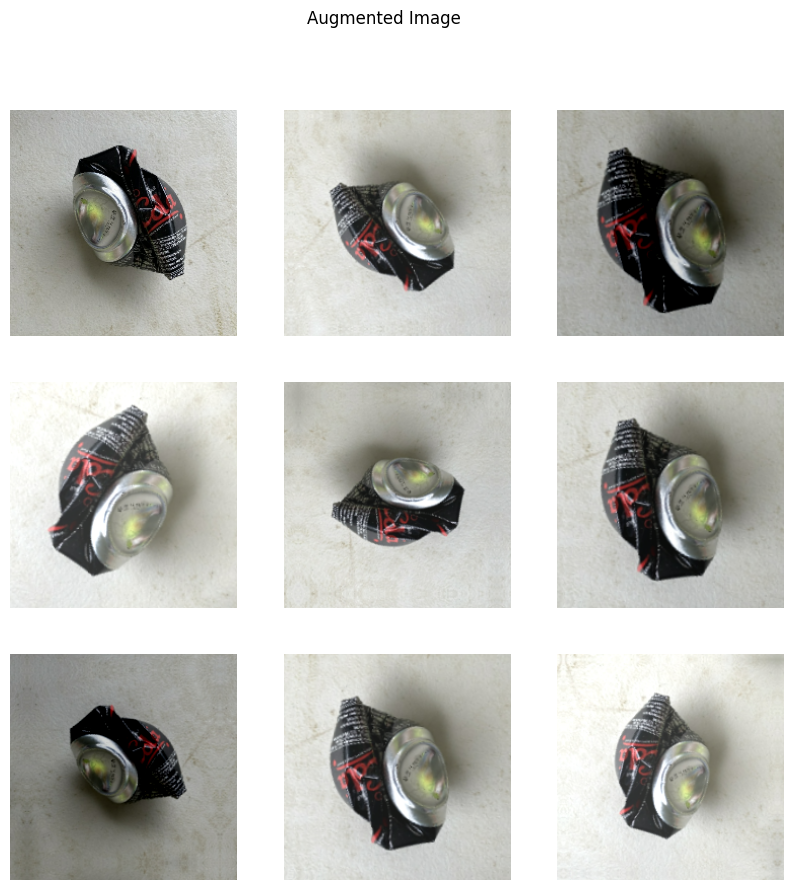

In [9]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]


    augmented_images = [image]
    for _ in range(8):
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])


    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle('Augmented Image')
    plt.show()


visualize_dataset(dataset, class_names)

In [10]:

def normalize_and_encode(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label


In [11]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [12]:

train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size


train_dataset = dataset.take(train_size).map(augment).map(normalize_and_encode)
remaining_dataset = dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size).map(normalize_and_encode)
test_dataset = remaining_dataset.skip(val_size).map(normalize_and_encode)

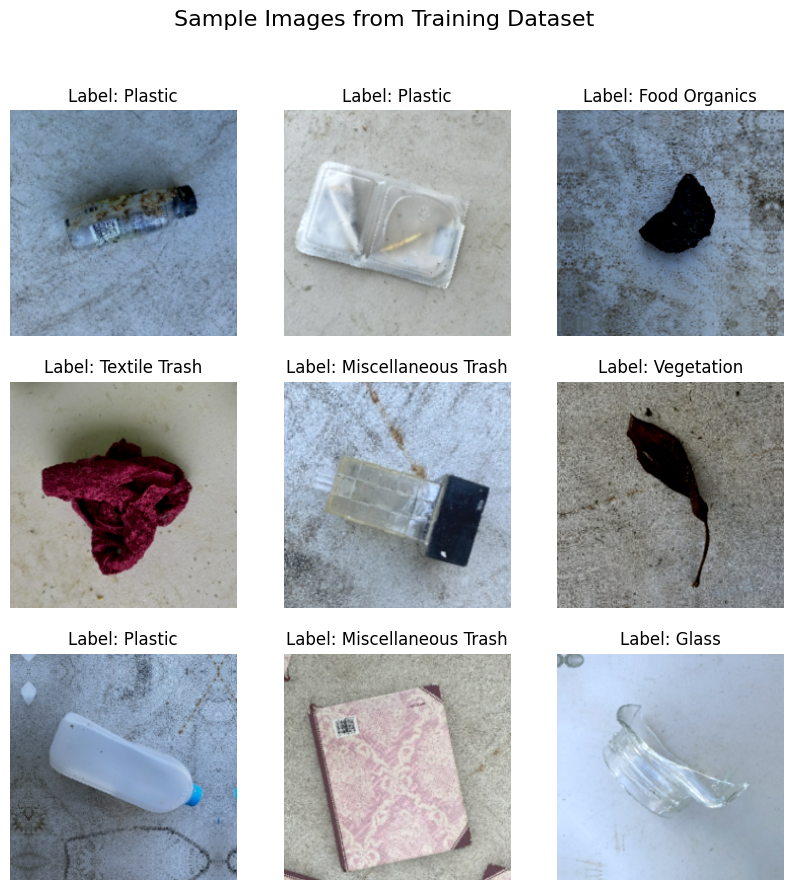

In [13]:
def decode_label(label):
    class_index = tf.argmax(label).numpy()
    return class_names[class_index]

def denormalize(image):
    image = image * 255
    image = tf.cast(image, tf.uint8)
    return image

def visualize_train_dataset(train_dataset, num_images=9):
    plt.figure(figsize=(10, 10))

    for images, labels in train_dataset.take(1):
        for i in range(min(num_images, len(images))):
            plt.subplot(3, 3, i + 1)
            img = denormalize(images[i])
            plt.imshow(img.numpy())
            plt.title(f"Label: {decode_label(labels[i])}")
            plt.axis("off")
    plt.suptitle("Sample Images from Training Dataset", fontsize=16)
    plt.show()


visualize_train_dataset(train_dataset)

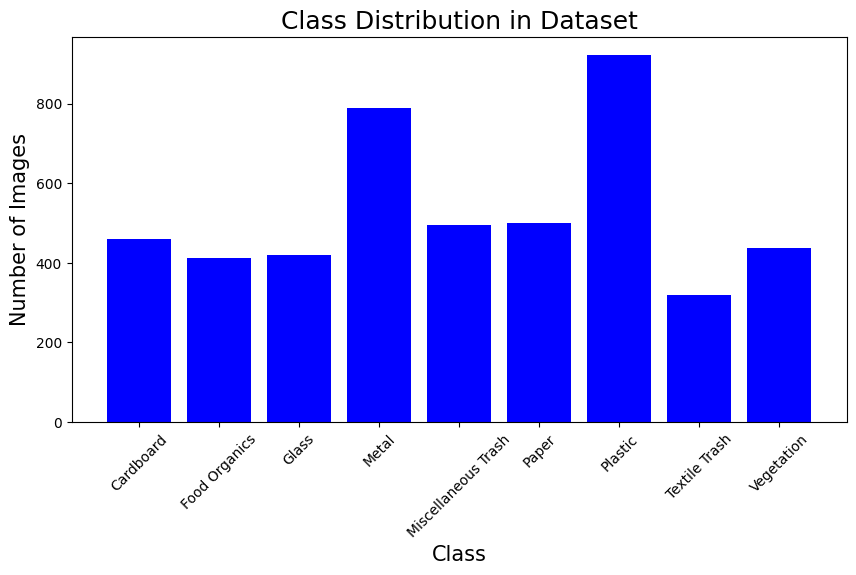

In [14]:



class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}


plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

In [15]:

train_labels = []


for batch in train_dataset.as_numpy_iterator():
    labels = batch[1]


    if labels.ndim > 1:
        labels = np.argmax(labels, axis=1)

    train_labels.extend(labels)


train_labels = np.array(train_labels)


class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}


print("Class weights:", class_weights_dict)


Class weights: {0: np.float64(1.1448228414172688), 1: np.float64(1.3495539334955393), 2: np.float64(1.2534839924670433), 3: np.float64(0.6924677486475239), 4: np.float64(1.0595351798790194), 5: np.float64(1.0718196457326892), 6: np.float64(0.5502645502645502), 7: np.float64(1.6808080808080808), 8: np.float64(1.170182841068917)}


In [16]:

def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal loss for multi-class classification with one-hot labels.
    """
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)

    return loss

In [17]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:

        return float(lr * tf.math.exp(-0.1))


In [18]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [88]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = True


model_base = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.60),
    layers.Dense(256, activation="relu",),
    layers.Dense(9, activation="softmax")
])


model_base.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss= categorical_focal_loss(),
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss",
                               patience=3,
                               restore_best_weights=True,
                               verbose=1)
lr_scheduler = LearningRateScheduler(scheduler)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history_base_model = model_base.fit(train_dataset, validation_data=val_dataset, epochs=35,  callbacks=[ lr_scheduler, reduce_lr])



Epoch 1/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 116s 479ms/step - accuracy: 0.2306 - loss: 0.6005 - val_accuracy: 0.0909 - val_loss: 0.4388 - learning_rate: 1.0000e-04
Epoch 2/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 440ms/step - accuracy: 0.4820 - loss: 0.2987 - val_accuracy: 0.1108 - val_loss: 0.4657 - learning_rate: 1.0000e-04
Epoch 3/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 442ms/step - accuracy: 0.5564 - loss: 0.2311 - val_accuracy: 0.1392 - val_loss: 0.4606 - learning_rate: 1.0000e-04
Epoch 4/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 47s 445ms/step - accuracy: 0.6317 - loss: 0.1872 - val_accuracy: 0.1080 - val_loss: 0.6526 - learning_rate: 1.0000e-04
Epoch 5/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 441ms/step - accuracy: 0.6764 - loss: 0.1681 - val_accuracy: 0.4134 - val_loss: 0.3317 - learning_rate: 5.0000e-05
Epoch 6/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 47s 447ms/step - accuracy: 0.6909 - loss: 0.1447 - val_accuracy: 0.3878 - val_loss: 0.3193 - learning_rate: 4.5242e-05
Epoch 7/35
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 4

In [ ]:
model_base.save('/content/drive/MyDrive/my_basemodel.h5')

In [ ]:

y_true_base = []
y_pred_probs_base = []

for images, labels in val_dataset:
    preds = model_base.predict(images)
    y_true_base.extend(labels.numpy())
    y_pred_probs_base.extend(preds)

y_pred_probs_base = np.array(y_pred_probs_base)
y_true_base = np.array(y_true_base)


y_pred_base = np.argmax(y_pred_probs_base, axis=1)



In [ ]:

if y_pred_base.ndim > 1:
    y_pred_base = np.argmax(y_pred_base, axis=1)


if y_true_base.ndim > 1:
    y_true_base = np.argmax(y_true_base, axis=1)


print(classification_report(y_true_base, y_pred_base))

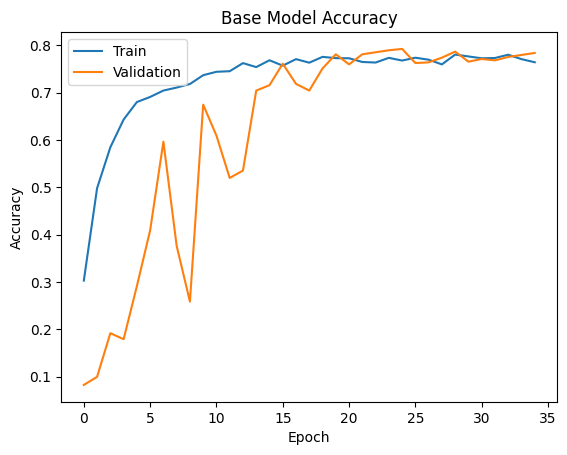

In [32]:
def plot_hist(history):
    plt.plot(history_base_model.history["accuracy"])
    plt.plot(history_base_model.history["val_accuracy"])
    plt.title("Base Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history_base_model)

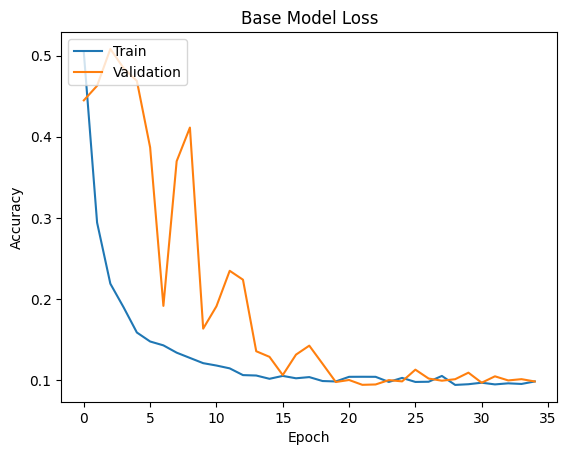

In [33]:
def plot_hist(history):
    plt.plot(history_base_model.history["loss"])
    plt.plot(history_base_model.history["val_loss"])
    plt.title("Base Model Loss")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history_base_model)

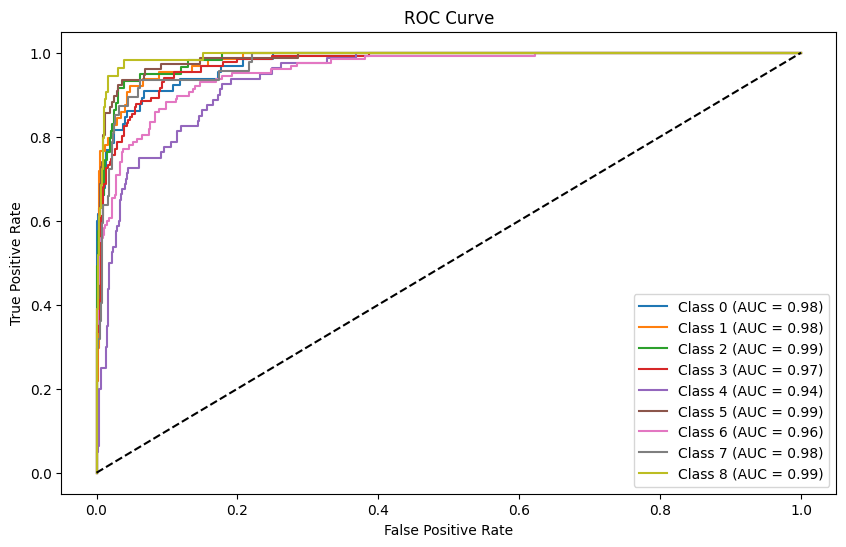

In [34]:

num_classes = 9
y_true_one_hot = to_categorical(y_true_base, num_classes)


plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs_base[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

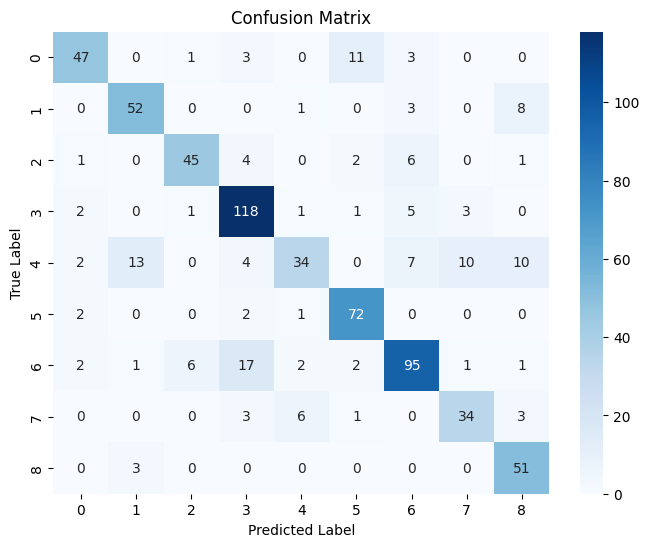

In [35]:

cm = confusion_matrix(y_true_base, y_pred_base)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [36]:

test_loss_base, test_acc_base = model_base.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc_base:.4f}")
print(f"Test Loss: {test_loss_base:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 709ms/step - accuracy: 0.7372 - loss: 0.1078
Test Accuracy: 0.7736
Test Loss: 0.0989


In [109]:

def build_model(hp):
    base_model = keras.applications.EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


    trainable = hp.Boolean('trainable', default=False)
    base_model.trainable = trainable

    if trainable:
        num_unfrozen_layers = hp.Int("unfreeze_layers", min_value=5, max_value=10, step=2)
        for layer in base_model.layers[-num_unfrozen_layers:]:
            layer.trainable = True


    optimizer_choice = hp.Choice("optimizer", ["adam", "sgd", "rmsprop"])
    optimizer = {
        "adam": keras.optimizers.Adam,
        "sgd": keras.optimizers.SGD,
        "rmsprop": keras.optimizers.RMSprop
    }[optimizer_choice](learning_rate=hp.Choice("learning_rate", [1e-3, 1e-4, 1e-5, 1e-6]))

    model_tuned = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(hp.Float("dropout_rate", min_value=0.4, max_value=0.8, step=0.1)),
        layers.Dense(hp.Int("units", min_value=64, max_value=512, step=64),
                     activation=hp.Choice("activation", ["relu", "elu", "swish"]),
                     kernel_regularizer=tf.keras.regularizers.l2(
                         hp.Float("l2", min_value=0.001, max_value=0.01, step=0.001))),
        layers.Dense(9, activation="softmax")
    ])

    model_tuned.compile(
        optimizer=optimizer,
        loss=categorical_focal_loss(),
        metrics=["accuracy"]
    )
    return model_tuned



In [111]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    directory="hyperparameter_tuning",
    project_name="efficientnet_tuning"
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

In [112]:
tuner.search(train_dataset, validation_data=val_dataset, epochs=15, callbacks=[early_stopping, lr_scheduler])


best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]




Trial 3 Complete [00h 24m 17s]
val_accuracy: 0.19460227340459824

Best val_accuracy So Far: 0.4495738446712494
Total elapsed time: 01h 03m 03s


In [113]:
best_model = tuner.hypermodel.build(best_hp)
history_tuned = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    class_weight=class_weights_dict,
    callbacks=[ lr_scheduler]
)


Epoch 1/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 112s 466ms/step - accuracy: 0.3091 - loss: 2.9568 - val_accuracy: 0.1023 - val_loss: 2.1844 - learning_rate: 0.0010
Epoch 2/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 435ms/step - accuracy: 0.5104 - loss: 1.8324 - val_accuracy: 0.1165 - val_loss: 1.5078 - learning_rate: 0.0010
Epoch 3/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 439ms/step - accuracy: 0.5787 - loss: 1.1625 - val_accuracy: 0.1378 - val_loss: 1.0930 - learning_rate: 0.0010
Epoch 4/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 438ms/step - accuracy: 0.6140 - loss: 0.7437 - val_accuracy: 0.0895 - val_loss: 1.3390 - learning_rate: 0.0010
Epoch 5/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 436ms/step - accuracy: 0.6586 - loss: 0.4904 - val_accuracy: 0.0739 - val_loss: 0.9304 - learning_rate: 0.0010
Epoch 6/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 46s 440ms/step - accuracy: 0.7015 - loss: 0.3151 - val_accuracy: 0.0994 - val_loss: 1.2252 - learning_rate: 0.0010
Epoch 7/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.7

In [114]:
best_model.save('/content/drive/MyDrive/my_basemodel.h5')

In [110]:
rm -rf hyperparameter_tuning/efficientnet_tuning/


In [115]:
tuner.results_summary()


Results summary
Results in hyperparameter_tuning/efficientnet_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
trainable: True
optimizer: adam
learning_rate: 0.001
dropout_rate: 0.8
units: 256
activation: swish
l2: 0.006
unfreeze_layers: 5
Score: 0.4495738446712494

Trial 2 summary
Hyperparameters:
trainable: False
optimizer: rmsprop
learning_rate: 0.001
dropout_rate: 0.8
units: 256
activation: swish
l2: 0.004
unfreeze_layers: 5
Score: 0.19460227340459824

Trial 1 summary
Hyperparameters:
trainable: True
optimizer: rmsprop
learning_rate: 1e-06
dropout_rate: 0.4
units: 448
activation: elu
l2: 0.009000000000000001
unfreeze_layers: 9
Score: 0.15625


In [116]:
y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = best_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Actual labels
    y_pred.extend(np.argmax(predictions, axis=1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


In [117]:

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.81      0.92      0.86        60
      Food Organics       0.95      0.90      0.93        62
              Glass       0.95      0.98      0.96        53
              Metal       0.90      0.94      0.92       125
Miscellaneous Trash       0.88      0.77      0.82        88
              Paper       0.90      0.91      0.91        82
            Plastic       0.93      0.82      0.87       132
      Textile Trash       0.81      0.94      0.87        49
         Vegetation       0.88      0.96      0.92        53

           accuracy                           0.89       704
          macro avg       0.89      0.91      0.90       704
       weighted avg       0.90      0.89      0.89       704



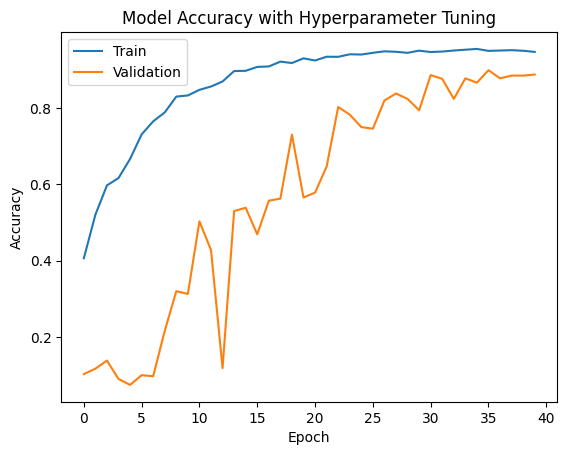

In [118]:
def plot_hist(history):
    plt.plot(history_tuned.history["accuracy"])
    plt.plot(history_tuned.history["val_accuracy"])
    plt.title("Model Accuracy with Hyperparameter Tuning")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history_tuned)

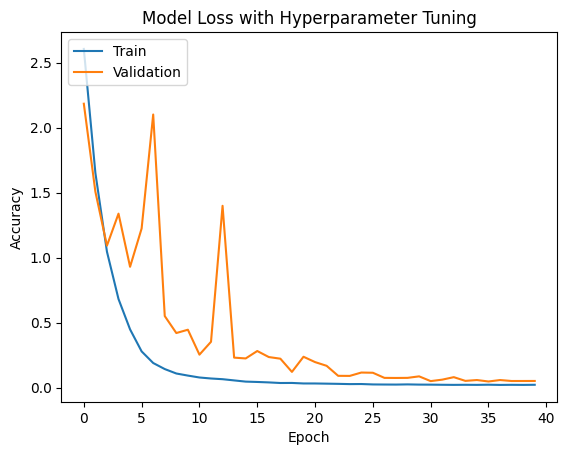

In [119]:
def plot_hist(history_tuned):
    plt.plot(history_tuned.history["loss"])
    plt.plot(history_tuned.history["val_loss"])
    plt.title("Model Loss with Hyperparameter Tuning")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history_tuned)

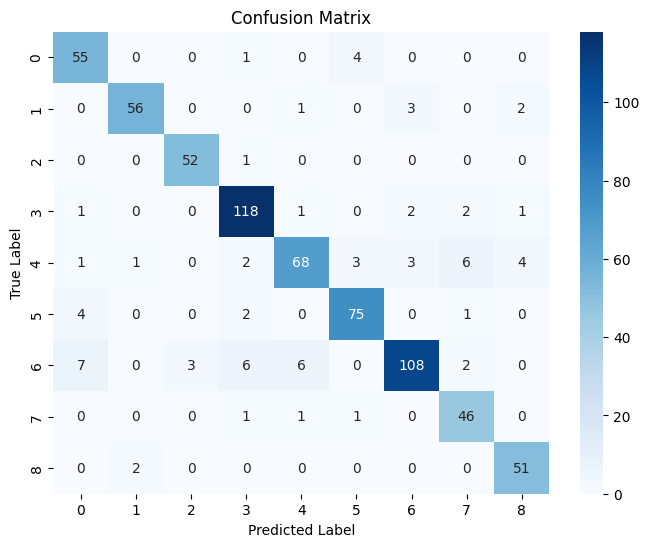

In [120]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [122]:
best_model.save("best_efficientnet_model.keras", include_optimizer=False)


In [121]:
model = load_model("best_efficientnet_model.keras")
test_loss_tuned, test_acc_tuned = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc_tuned:.4f}")
print(f"Test Loss: {test_loss_tuned:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 182ms/step - accuracy: 0.8622 - loss: 1.3657
Test Accuracy: 0.8458
Test Loss: 1.4141
